In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')
sys.path.append("/Users/marissac/Documents/COCOText/coco-text-master")
import caffe
import coco_text


import sys


#caffe.set_device(0)
#caffe.set_mode_cpu()

from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL COCO labels
coco_labelmap_file = '/Users/marissac/caffe/data/coco/labelmap_cocoText.prototxt'
file = open(coco_labelmap_file, 'r')
coco_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), coco_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    print num_labels
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

model_def = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/test.prototxt'
model_weights = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/cocotext_v5_iter_50000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB



2
0


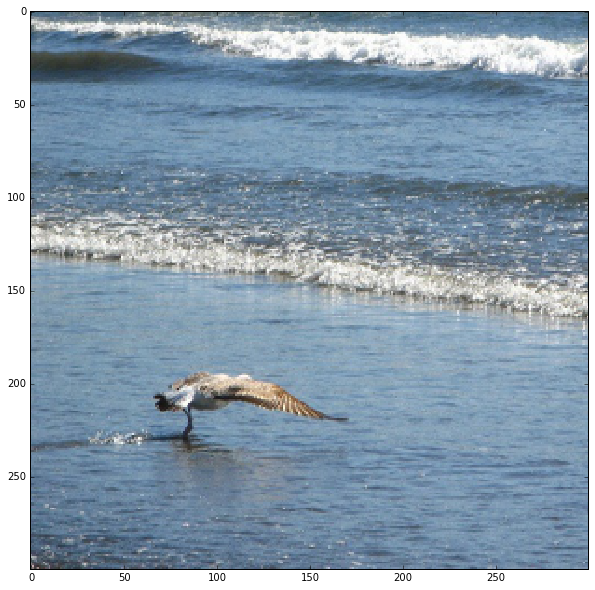

In [35]:
# set net to batch size of 1
#image_resize = 300
#net.blobs['data'].reshape(1,3,image_resize,image_resize)
    
# Forward pass.
net.forward()

detections = net.blobs['detection_out'].data
detection_eval = net.blobs['detection_eval'].data
#detections = net.forward()['detection_out']

#image = caffe.io.load_image('/Users/marissac/caffe/examples/images/cat.jpg')
image_blob = net.blobs['data'].data
image = transformer.deprocess('data', image_blob)
image_resize = 500

imageTemp = image;

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.23]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(coco_labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.imshow(image)
currentAxis = plt.gca()

print top_conf.shape[0]
for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = top_labels[i]
    name = '%s: %.2f'%(label, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[i % len(colors)]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})